In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import pycountry
import geopandas as gpd

In [83]:
eur=pd.read_csv('/Users/mac/Downloads/egyetem/2025_02_ősz/KORMI1/data (1).csv')

## Filter the dataset based on the the previous notebook

In [85]:
df=eur.loc[
    ~eur.REF_AREA.isin(['HR', 'LT', 'LV', 'NL', 'I9']),
    ['KEY', 'TIME_PERIOD', 'REF_AREA', 'ACCOUNT_ENTRY', 'INSTR_ASSET', 'DWA_GRP', 'OBS_VALUE', 'UNIT_MEASURE', 'TITLE']]

In [109]:
df["TIME_PERIOD"] = pd.PeriodIndex(df["TIME_PERIOD"], freq="Q").to_timestamp()

In [118]:
df=df[df.TIME_PERIOD>'2014-09-01']

In [119]:
df

,KEY,TIME_PERIOD,REF_AREA,ACCOUNT_ENTRY,INSTR_ASSET,DWA_GRP,OBS_VALUE,UNIT_MEASURE,TITLE
16,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2014-10-01,AT,A,F2M,B50,33250.67,EUR,Deposits of households - Bottom 50% based on n...
17,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-01-01,AT,A,F2M,B50,33566.78,EUR,Deposits of households - Bottom 50% based on n...
18,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-04-01,AT,A,F2M,B50,33593.99,EUR,Deposits of households - Bottom 50% based on n...
19,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-07-01,AT,A,F2M,B50,33538.23,EUR,Deposits of households - Bottom 50% based on n...
20,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-10-01,AT,A,F2M,B50,34342.17,EUR,Deposits of households - Bottom 50% based on n...
...,...,...,...,...,...,...,...,...,...
636695,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-01-01,SK,_Z,NWA,_Z,56.86,GI,Gini coefficient of households
636696,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-04-01,SK,_Z,NWA,_Z,56.61,GI,Gini coefficient of households
636697,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-07-01,SK,_Z,NWA,_Z,56.36,GI,Gini coefficient of households
636698,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-10-01,SK,_Z,NWA,_Z,56.19,GI,Gini coefficient of households


## Get countries' border data
It's a good time to remind: do not trust on LLMs, they still say a lot of dumbs. </br>
Data is from: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [40]:
path='ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'
cntrs=gpd.read_file(path)[['ISO_A2_EH','geometry']]
borders=cntrs.loc[cntrs.ISO_A2_EH.isin(df.REF_AREA.unique()),:]
borders

## Start of the analysis
Mean and median

In [102]:
df.UNIT_MEASURE.unique()

array(['EUR', 'EUR_R_NH', 'EUR_R_POP', 'EUR_MD', 'EUR_MN', 'PT', 'GI'],
      dtype=object)

In [113]:
df.loc[df.UNIT_MEASURE=='EUR_MD'].TITLE.unique()

array(['Median net wealth of households'], dtype=object)

In [182]:
median_order=df[df.UNIT_MEASURE=='EUR_MD'].sort_values(by='OBS_VALUE', ascending=False).REF_AREA.unique()

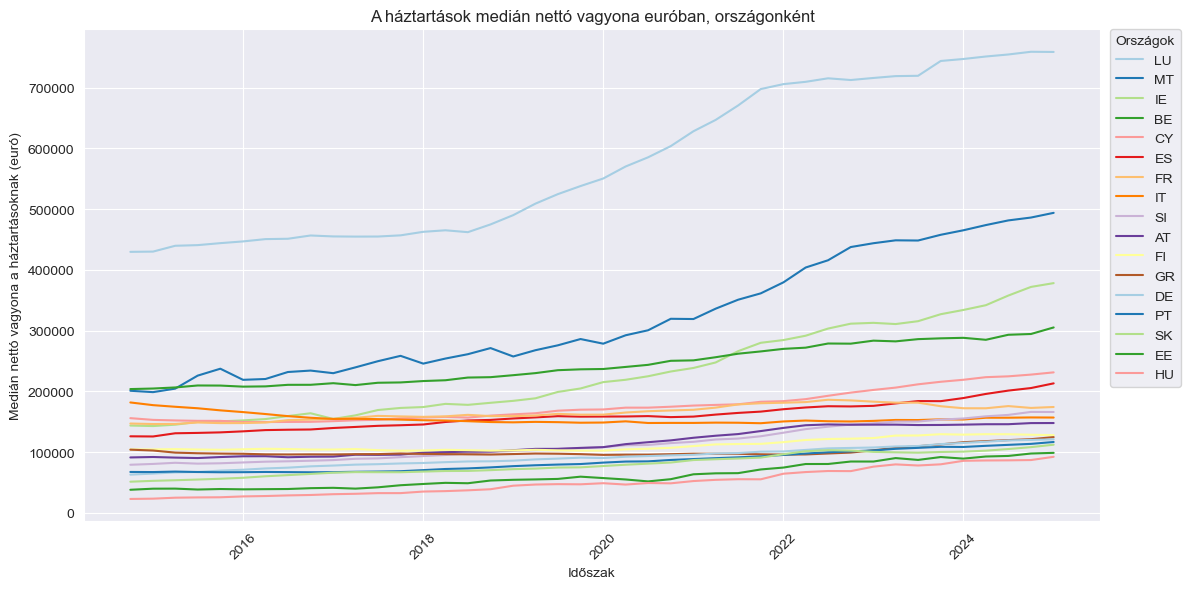

In [184]:
# median
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df.UNIT_MEASURE=='EUR_MD'],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=median_order,
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak')
plt.ylabel('Medián nettó vagyona a háztartásoknak (euró)')
plt.title('A háztartások medián nettó vagyona euróban, országonként')
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

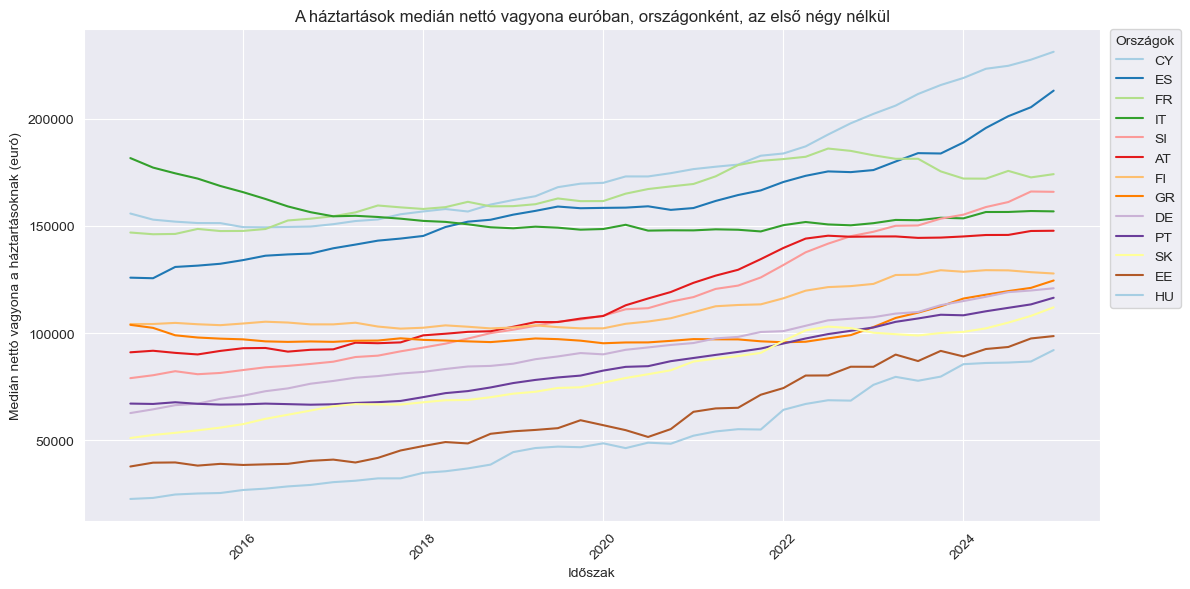

In [185]:
# median
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[(df.UNIT_MEASURE=='EUR_MD')&(~df.REF_AREA.isin(['LU','MT','IE','BE']))],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=median_order[4::],
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak')
plt.ylabel('Medián nettó vagyona a háztartásoknak (euró)')
plt.title('A háztartások medián nettó vagyona euróban, országonként, az első négy nélkül')
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [187]:
mean_order=df[df.UNIT_MEASURE=='EUR_MN'].sort_values(by='OBS_VALUE', ascending=False).REF_AREA.unique()

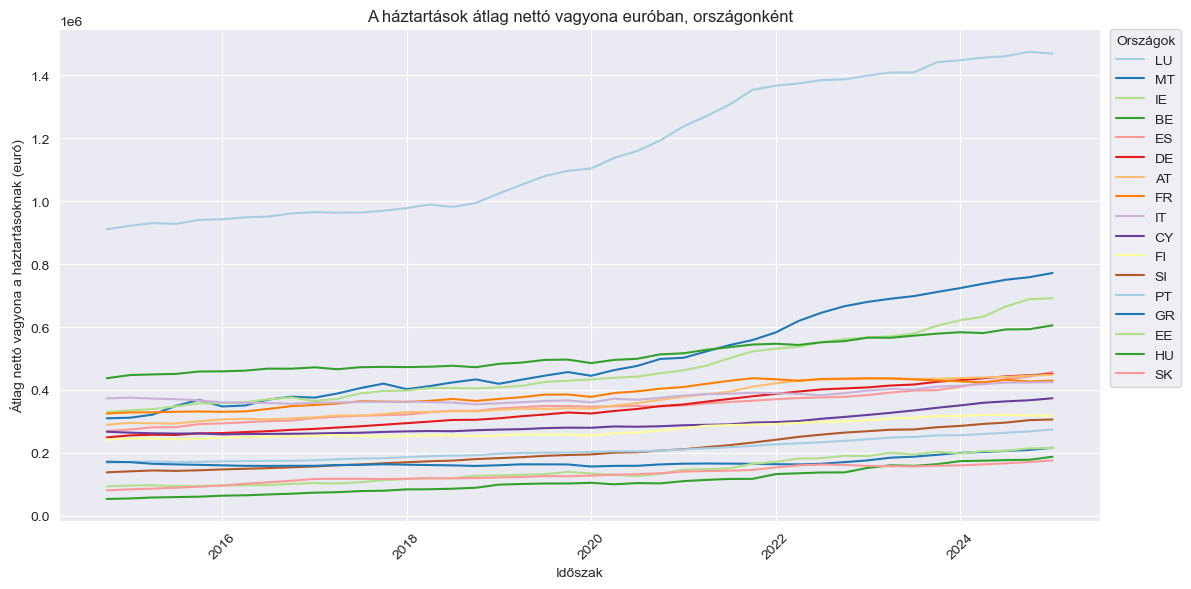

In [192]:
# mean
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df.UNIT_MEASURE=='EUR_MN'],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=mean_order,
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak')
plt.ylabel('Átlag nettó vagyona a háztartásoknak (euró)')
plt.title('A háztartások átlag nettó vagyona euróban, országonként')
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

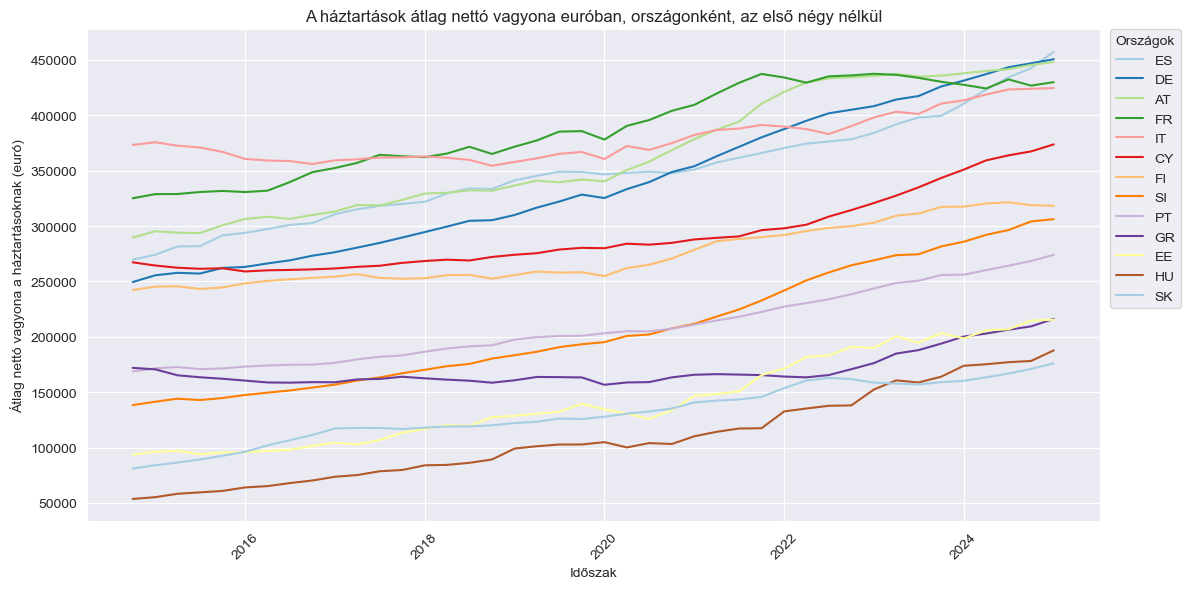

In [194]:
# mean
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[(df.UNIT_MEASURE=='EUR_MN')&(~df.REF_AREA.isin(['LU','MT','IE','BE']))],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=mean_order[4::],
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak')
plt.ylabel('Átlag nettó vagyona a háztartásoknak (euró)')
plt.title('A háztartások átlag nettó vagyona euróban, országonként, az első négy nélkül')
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

## Composition of the wealth
Checking the columns below, for each country just for the last quarter. Always checking the per household value to compare the DWA groups.
- ACCOUNT_ENTRY --> assets, liabilities and the difference
- INSTR_ASSET
- DWA_GRP
Due to the limited time and passion, just compare the first and the last

### ACCOUNT_ENTRY
#### assets

In [282]:
composition=df[df.TIME_PERIOD=='2025-01-01']

In [345]:
assets=composition[(composition.ACCOUNT_ENTRY=='A')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                    (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))&(composition.INSTR_ASSET!='F_NNA')]
assets_pivot=assets.pivot_table(index='REF_AREA', columns='INSTR_ASSET', values='OBS_VALUE', aggfunc='sum')
assets_pivot=assets_pivot.iloc[assets_pivot.sum(axis=1).argsort()]

In [415]:
custom_labels = [
    'Nettó lakásvagyon',                            # NUN
    'Nem pénzügyi üzleti vagyon',                   # NUB
    'Életbiztosítási és járadékjogosultságok',      # F62
    'Befektetési alapok részvényei/egységei',       # F52
    'Nem jegyzett részvények és egyéb tőkeelemek',  # F51M
    'Tőzsdén jegyzett részvények',                  # F511
    'Kötvények',                                    # F3
    'Betétek'                                       # F2M
]

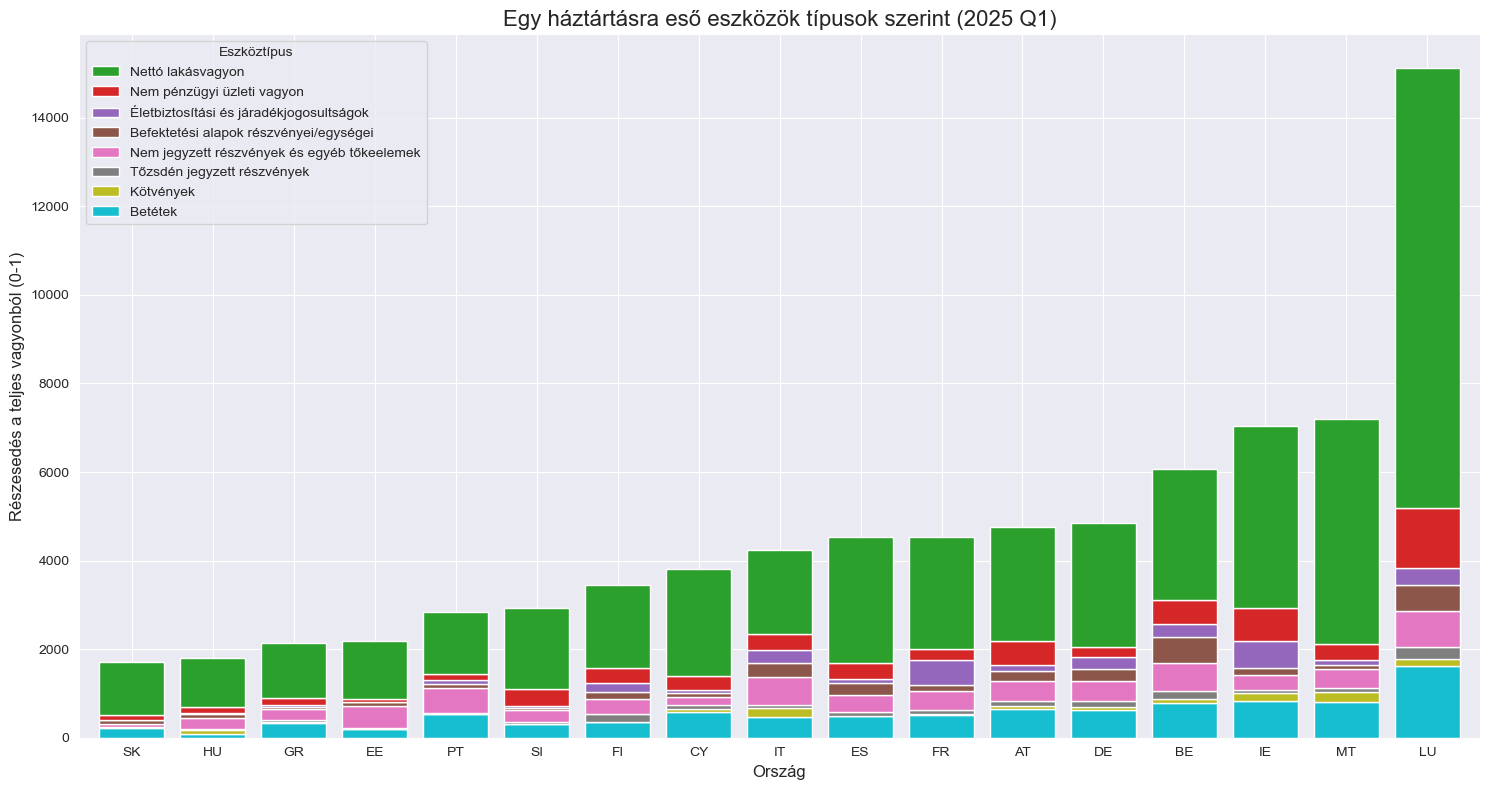

In [416]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = assets_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső eszközök típusok szerint (2025 Q1)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(handles=handles[::-1], title="Eszköztípus", loc='upper left',labels=custom_labels)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [417]:
assets_pivot_percent = assets_pivot.div(assets_pivot.sum(axis=1), axis=0)

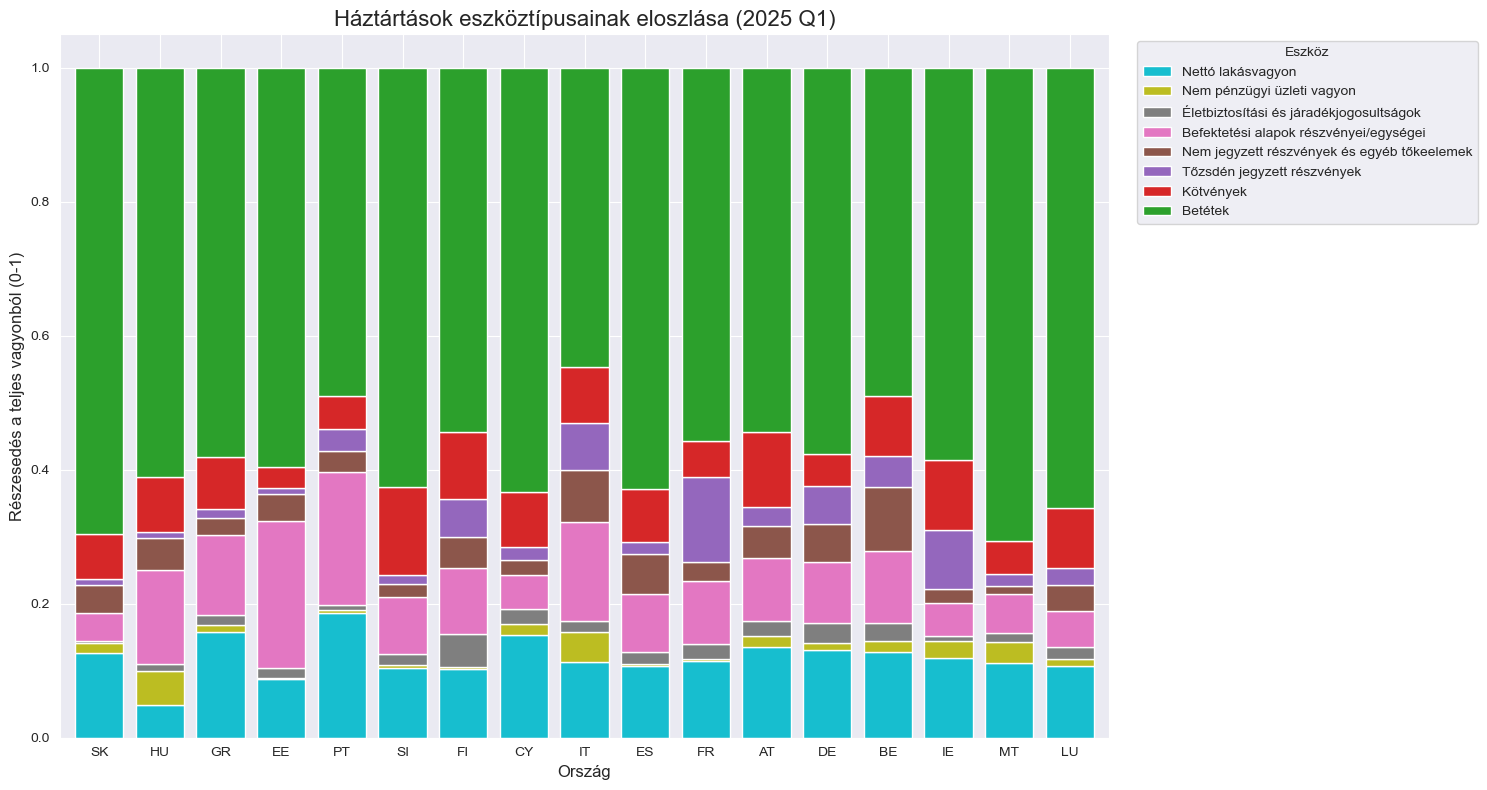

In [418]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = assets_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztártások eszköztípusainak eloszlása (2025 Q1)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(title="Eszköz", bbox_to_anchor=(1.02, 1), loc='upper left', labels=custom_labels)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Liabilities

In [394]:
liabilities=composition[(composition.ACCOUNT_ENTRY=='L')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                          (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))&(composition.INSTR_ASSET!='F_NNA')]
liabilities_pivot=liabilities.pivot_table(index='REF_AREA', columns='INSTR_ASSET', values='OBS_VALUE', aggfunc='sum')
liabilities_pivot=liabilities_pivot.iloc[liabilities_pivot.sum(axis=1).argsort()]
# liabilities_pivot=liabilities_pivot[['B50','D6','D7','D8','D9','D10']]

In [434]:
custom_labels2 = [
    'Lakásvásárláson kívüli hitelek',   # F4X
    'Lakásvásárlási hitelek'           # F4B
]

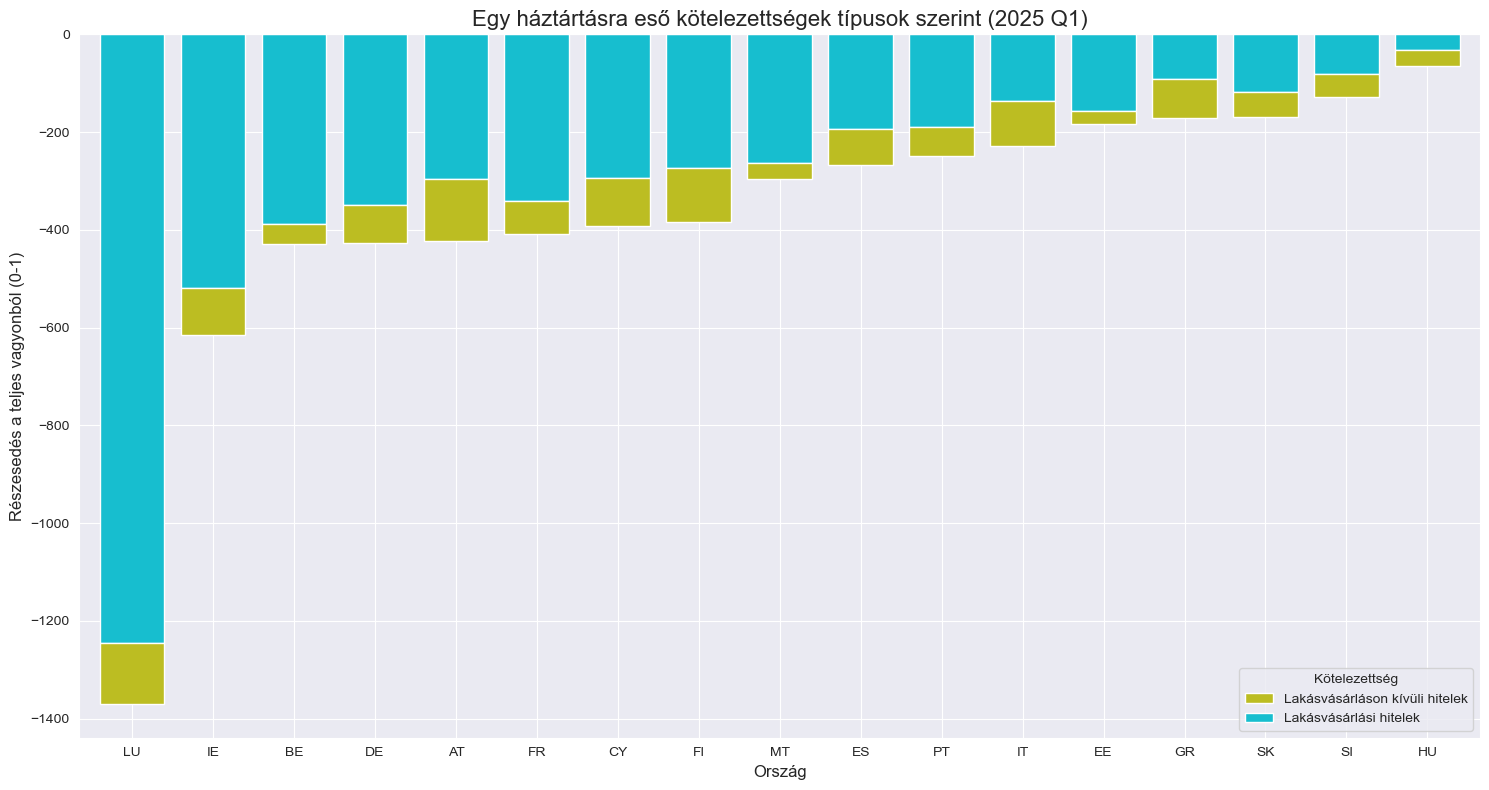

In [436]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = liabilities_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső kötelezettségek típusok szerint (2025 Q1)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(handles=handles[::-1], title="Kötelezettség", loc='lower right', labels=custom_labels2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [429]:
liabilities_pivot_percent = liabilities_pivot.div(liabilities_pivot.sum(axis=1), axis=0)

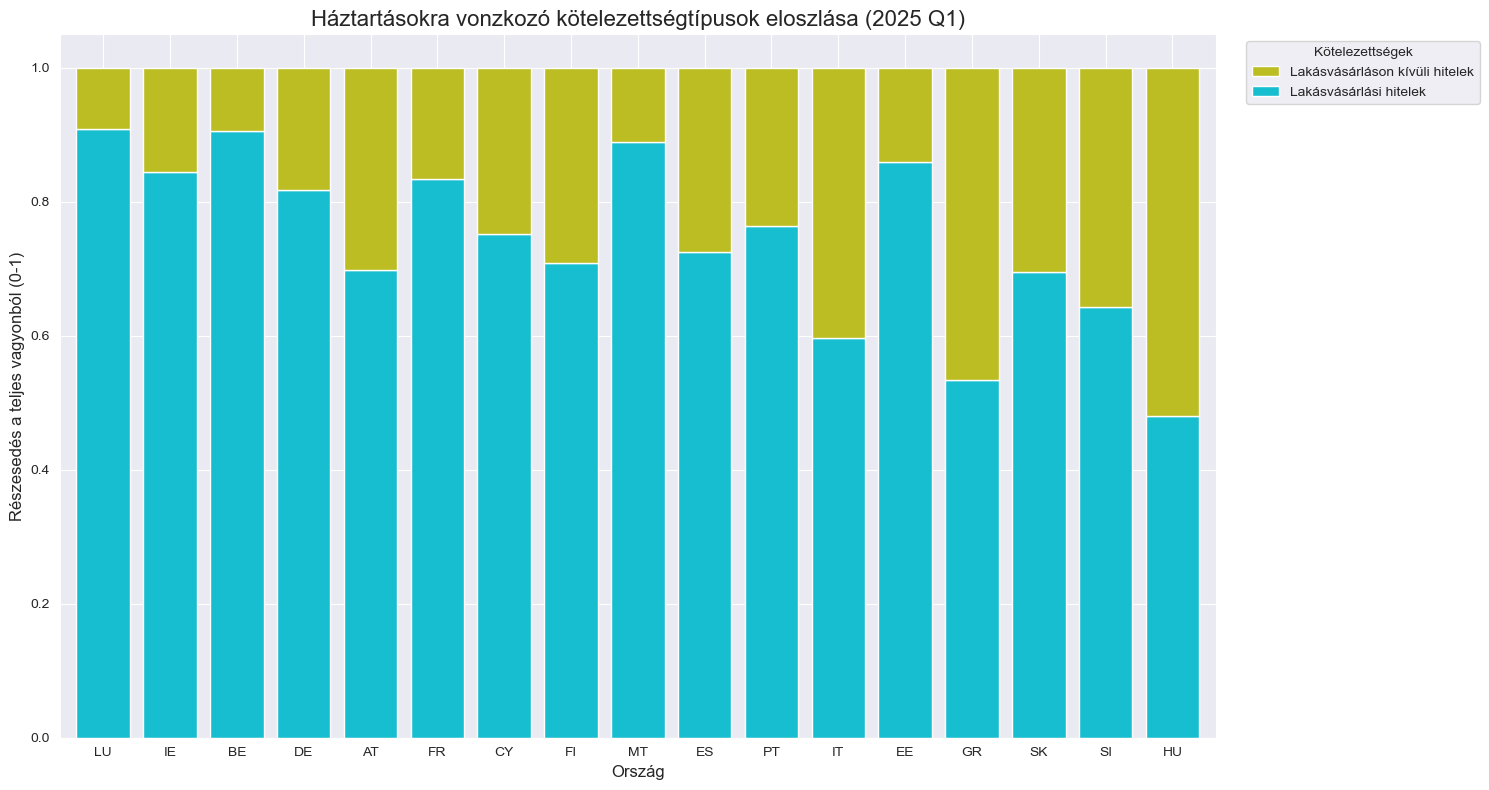

In [435]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = liabilities_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztartásokra vonzkozó kötelezettségtípusok eloszlása (2025 Q1)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(handles=handles[::-1], title="Kötelezettségek", bbox_to_anchor=(1.02, 1), loc='upper left', labels=custom_labels2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Net

In [275]:
accounts_diff=composition[(composition.ACCOUNT_ENTRY=='N')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                          (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))]
accounts_pivot=accounts_diff.pivot(index='REF_AREA', columns='DWA_GRP', values='OBS_VALUE')
accounts_pivot=accounts_pivot[['D10', 'D9', 'D8', 'D7', 'D6', 'B50']]
accounts_pivot = accounts_pivot.iloc[accounts_pivot.sum(axis=1).argsort()]

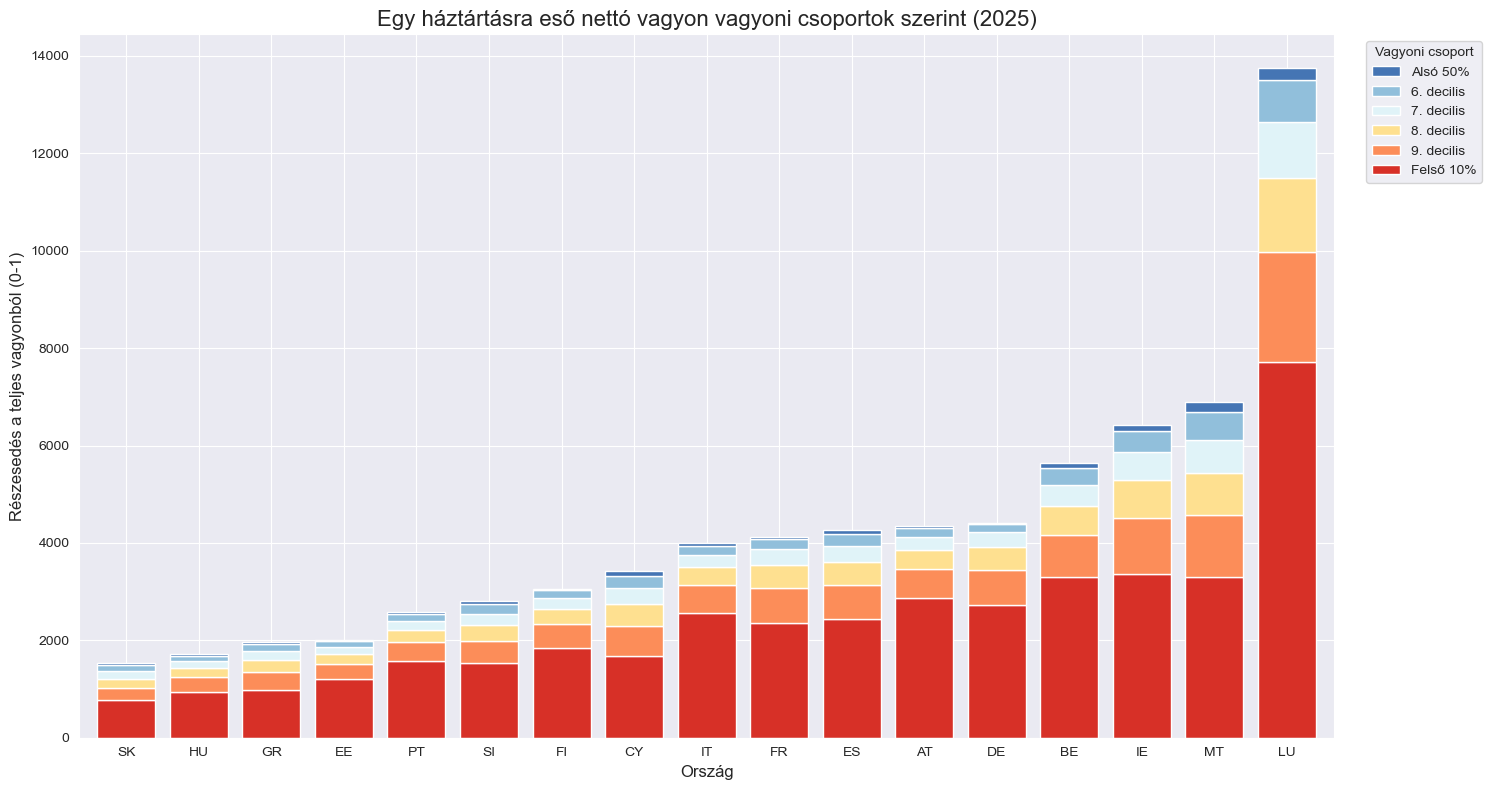

In [278]:
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
ax = accounts_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors, width=0.8)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső nettó vagyon vagyoni csoportok szerint (2025)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Alsó 50%', '6. decilis', '7. decilis', '8. decilis', '9. decilis', 'Felső 10%'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [258]:
accounts_pivot_percent = accounts_pivot.div(accounts_pivot.sum(axis=1), axis=0)

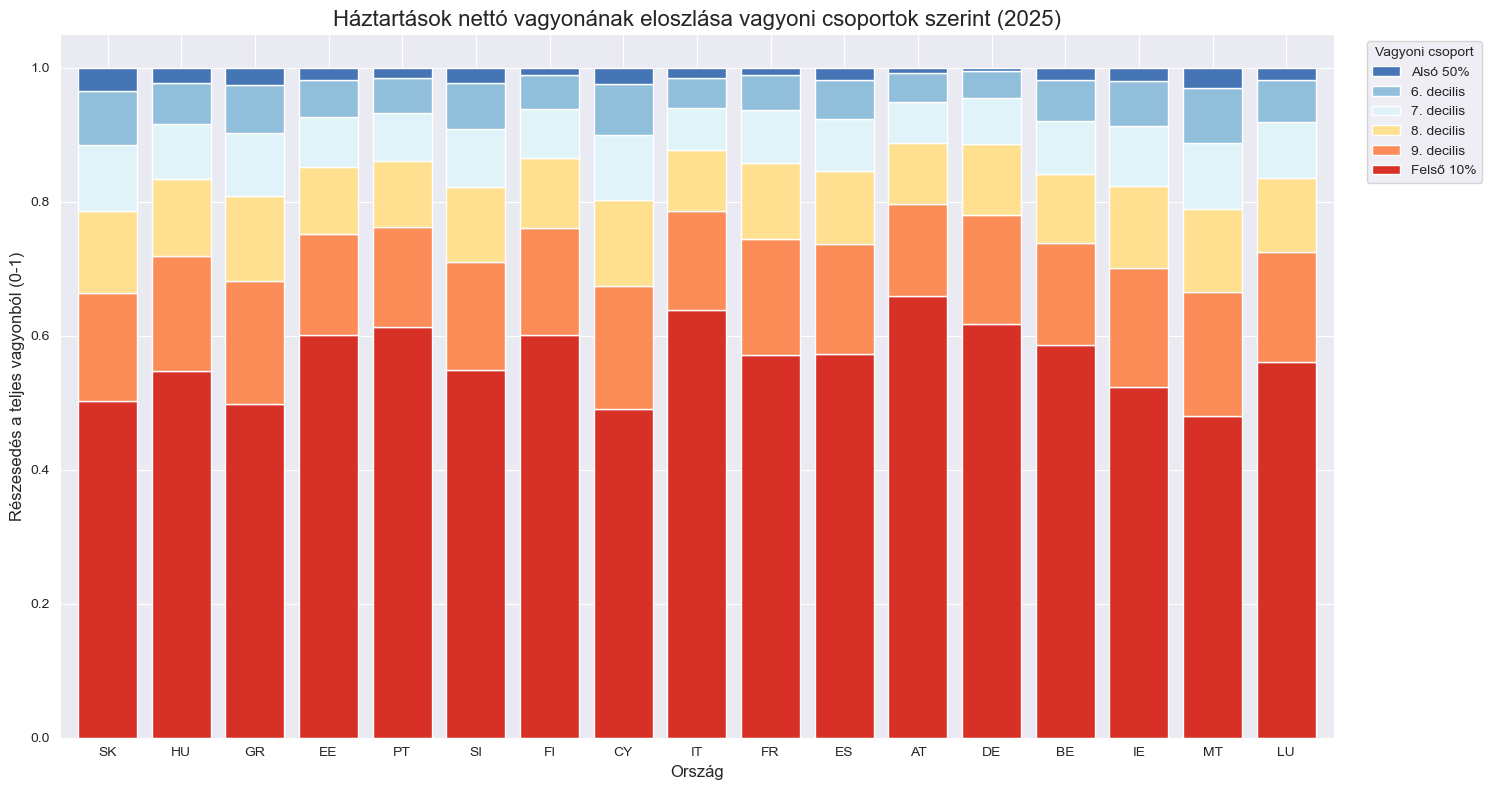

In [279]:
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
ax = accounts_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors, width=0.8)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztartások nettó vagyonának eloszlása vagyoni csoportok szerint (2025)", fontsize=16)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=12)
plt.xlabel("Ország", fontsize=12)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Alsó 50%', '6. decilis', '7. decilis', '8. decilis', '9. decilis', 'Felső 10%'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [281]:
accounts_pivot_percent

DWA_GRP,D10,D9,D8,D7,D6,B50
REF_AREA,,,,,,
SK,0.503248,0.161066,0.122405,0.097896,0.080186,0.035199
HU,0.548055,0.171829,0.114184,0.082392,0.061472,0.022068
GR,0.498706,0.182938,0.127404,0.094482,0.071632,0.024838
EE,0.601507,0.150349,0.100061,0.074201,0.056174,0.017709
PT,0.613304,0.148677,0.098529,0.071470,0.052689,0.015331
SI,0.548830,0.161425,0.111866,0.087166,0.067650,0.023063
FI,0.600963,0.160237,0.104001,0.073678,0.051261,0.009860
CY,0.490773,0.184066,0.128451,0.096461,0.076156,0.024093
IT,0.638767,0.147340,0.090858,0.062762,0.045250,0.015023
